In [1]:
import os
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt

In [2]:
# dataset load
(ds_train, ds_test), ds_info = tfds.load(
    'cats_vs_dogs',
    split=['train[:80%]', 'train[80%:]'],
    shuffle_files=True,
    with_info=True,
)

In [3]:
print(ds_info.features)

FeaturesDict({
    'image': Image(shape=(None, None, 3), dtype=tf.uint8),
    'image/filename': Text(shape=(), dtype=tf.string),
    'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=2),
})


In [4]:
print(tf.data.experimental.cardinality(ds_train))
print(tf.data.experimental.cardinality(ds_test))

tf.Tensor(18610, shape=(), dtype=int64)
tf.Tensor(4652, shape=(), dtype=int64)


In [5]:
def normalize_and_resize_img(image, label):
    image = tf.image.resize(image, [32, 32])
    return tf.cast(image, tf.float32) / 255., label

def apply_normalize_on_dataset(ds, is_test=False, batch_size=16):
    ds = ds.map(normalize_and_resize_img, num_parallel_calls=1)
    ds = ds.batch(batch_size)
    if not is_test:
        ds = ds.repeat()
        ds = ds.shuffle(200)
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    return ds

In [6]:
ds_info.features['label'].num_classes

2

In [7]:
ds_info.features['label'].names

['cat', 'dog']

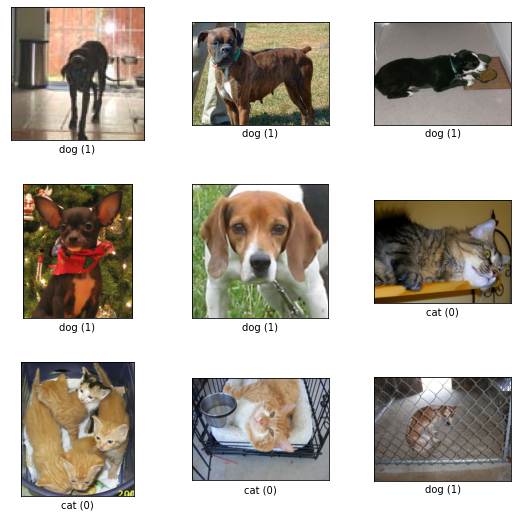

In [8]:
fig = tfds.show_examples(ds_train, ds_info)

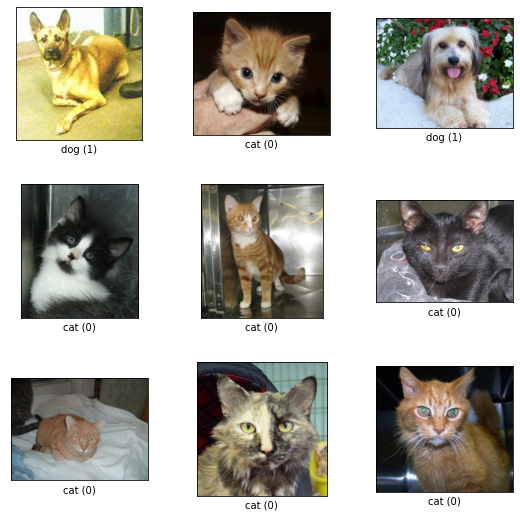

In [9]:
fig = tfds.show_examples(ds_test, ds_info)

In [10]:
def build_resnet_residual(x, channel, kernel_size=3, stride=1, conv_shortcut=False, is_plain=False):
    # skip-connection
    if conv_shortcut:
        shortcut = layers.Conv2D(channel, 1, strides=stride, padding='same')(x)
        shortcut = layers.BatchNormalization()(shortcut)

    else:
        shortcut = x     
    
    # CNN layer
    if conv_shortcut:
        x1 = layers.Conv2D(filters=channel, kernel_size=3, strides=2, padding='same')(x)
    else:
        x1 = layers.Conv2D(channel, 3, strides=1, padding='same')(x)
    x1 = layers.BatchNormalization()(x1)
    x1 = layers.ReLU()(x1)

    x1 = layers.Conv2D(channel, 3, strides=1, padding='same')(x1)
    x1 = layers.BatchNormalization()(x1)
    
    if is_plain:
        x1 = layers.ReLU()(x1)
        return x1
    else:
        x = layers.Add()([x1, shortcut])
        x = layers.ReLU()(x)
        return x

In [11]:
def build_resnet_bottleneck(x, channel, kernel_size=3, stride=1, conv_shortcut=False, is_plain=False):
    # skip-connection
    if conv_shortcut:
        shortcut = layers.Conv2D(channel * 4, 1, strides=stride, padding='same')(x)
        shortcut = layers.BatchNormalization()(shortcut)

    else:
        shortcut = x
    
    # CNN layer
    if conv_shortcut:
        x1 = layers.Conv2D(channel, 1, strides=stride, padding='same')(x)
    else:
        x1 = layers.Conv2D(channel, 1, strides=1, padding='same')(x)
    x1 = layers.BatchNormalization()(x1)
    x1 = layers.ReLU()(x1)

    x1 = layers.Conv2D(channel, 3, strides=1, padding='same')(x1)
    x1 = layers.BatchNormalization()(x1)
    x1 = layers.ReLU()(x1)
    
    x1 = layers.Conv2D(channel * 4, 1, strides=1, padding='same')(x1)
    x1 = layers.BatchNormalization()(x1)
    
    if is_plain:
        x1 = layers.ReLU()(x1)
        return x1
    else:
        x = layers.Add()([x1, shortcut])
        x = layers.ReLU()(x)
        return x

In [12]:
def build_resnet_blocks(input_layer, 
                        num_cnn=3, 
                        channel=64, 
                        strides=1,
                        block_num=0, 
                        is_plain=False, 
                        is_50=False):
    # input layer
    x = input_layer
    if is_50:
        for i in range(num_cnn):
            if block_num == 2 and i == 0:
                x = build_resnet_bottleneck(x, channel, conv_shortcut=True, is_plain=is_plain)
            elif block_num != 2 and i == 0:
                x = build_resnet_bottleneck(x, channel, stride=2, conv_shortcut=True, is_plain=is_plain)
            else:
                x = build_resnet_bottleneck(x, channel, is_plain=is_plain)
    else:
        for i in range(num_cnn):
            if block_num != 2 and i == 0:
                x = build_resnet_residual(x, channel, stride=2, conv_shortcut=True, is_plain=is_plain)
            else:
                x = build_resnet_residual(x, channel, is_plain=is_plain)
        
    return x

In [13]:
def build_resnet(input_shape=(32, 32, 3), 
                 num_cnn_list=[3, 4, 6, 3], 
                 channel_list=[64, 128, 256, 512], 
                 num_classes=10, 
                 is_plain=False, 
                 is_50=False):
    
    assert len(num_cnn_list) == len(channel_list)
    
    input_layer = layers.Input(shape=input_shape)
    output = input_layer
    
    # conv1
    output = layers.Conv2D(64, kernel_size=(7, 7), strides=2, padding='same', name='conv1')(output)
    output = layers.BatchNormalization()(output)
    output = layers.ReLU()(output)
    output = layers.MaxPool2D(pool_size=(3, 3), strides=2, padding='same', name='conv2_maxpool2d')(output)
    
    for i, (num_cnn, channel) in enumerate(zip(num_cnn_list, channel_list)):
        output = build_resnet_blocks(output, 
                                    num_cnn=num_cnn, 
                                    channel=channel, 
                                    block_num=i+2,
                                    is_plain=is_plain,
                                    is_50=is_50)
        
    output = keras.layers.GlobalAveragePooling2D(name='average_pooling')(output)
    output = keras.layers.Flatten(name='flatten')(output)
    output = keras.layers.Dense(num_classes, activation='softmax', name='predictions')(output)
    
    model = keras.Model(inputs=input_layer, outputs=output)
    
    return model

# ResNet 34 Residual Model

In [14]:
resnet34_residual = build_resnet(input_shape=(32, 32, 3), num_classes=2)

In [15]:
resnet34_residual.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 16, 16, 64)   9472        input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 16, 16, 64)   256         conv1[0][0]                      
__________________________________________________________________________________________________
re_lu (ReLU)                    (None, 16, 16, 64)   0           batch_normalization[0][0]        
______________________________________________________________________________________________

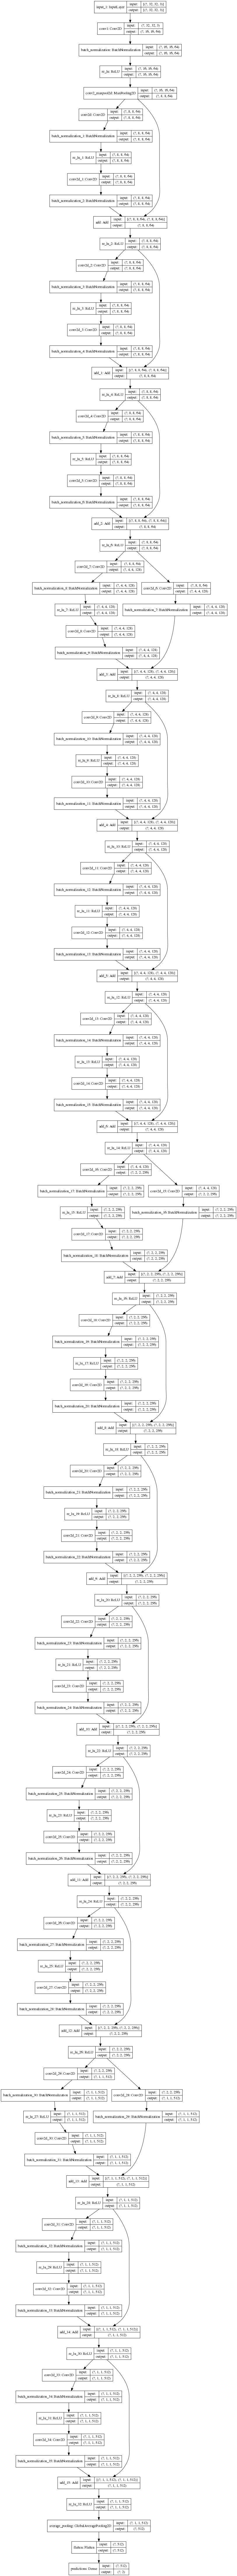

In [16]:
tf.keras.utils.plot_model(resnet34_residual, show_shapes=True, dpi=64)

# ResNet 34 Plain Model

In [17]:
resnet34_plain = build_resnet(input_shape=(32, 32, 3), is_plain=True, num_classes=2)

In [18]:
resnet34_plain.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 16, 16, 64)        9472      
_________________________________________________________________
batch_normalization_36 (Batc (None, 16, 16, 64)        256       
_________________________________________________________________
re_lu_33 (ReLU)              (None, 16, 16, 64)        0         
_________________________________________________________________
conv2_maxpool2d (MaxPooling2 (None, 8, 8, 64)          0         
_________________________________________________________________
conv2d_35 (Conv2D)           (None, 8, 8, 64)          36928     
_________________________________________________________________
batch_normalization_37 (Batc (None, 8, 8, 64)          256 

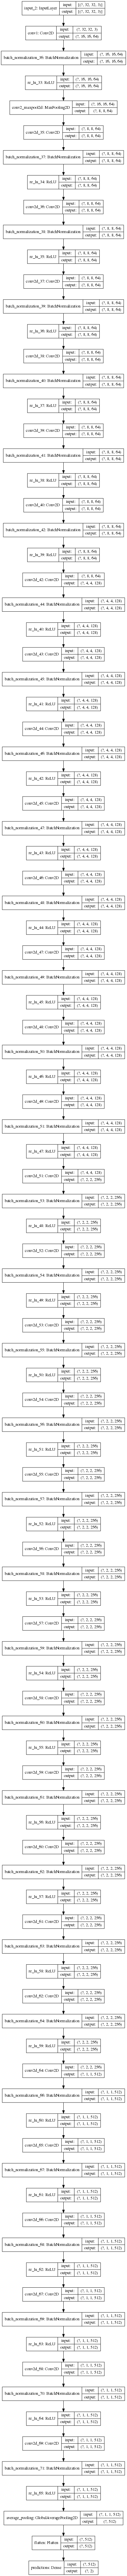

In [19]:
tf.keras.utils.plot_model(resnet34_plain, show_shapes=True, dpi=64)

# Train

In [20]:
BATCH_SIZE = 256
EPOCH = 50
# cats_vs_dogs dataset load
(ds_train, ds_test), ds_info = tfds.load(
    'cats_vs_dogs',
    split=['train[:80%]', 'train[80%:]'],
    as_supervised=True,
    shuffle_files=True,
    with_info=True,
)
ds_train = apply_normalize_on_dataset(ds_train, batch_size=BATCH_SIZE)
ds_test = apply_normalize_on_dataset(ds_test, batch_size=BATCH_SIZE)

In [21]:
# ResNet34-Plain
resnet34_plain.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01, clipnorm=1.),
    metrics=['accuracy'],
)

history_34_plain = resnet34_plain.fit(
    ds_train,
    steps_per_epoch=int(ds_info.splits['train[:80%]'].num_examples/BATCH_SIZE),
    validation_steps=int(ds_info.splits['train[80%:]'].num_examples/BATCH_SIZE),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/50
72/72 [==============================] - 28s 390ms/step - loss: 0.7629 - accuracy: 0.5062 - val_loss: 0.6924 - val_accuracy: 0.5202
Epoch 2/50
72/72 [==============================] - 9s 127ms/step - loss: 0.7376 - accuracy: 0.5005 - val_loss: 0.6968 - val_accuracy: 0.5015
Epoch 3/50
72/72 [==============================] - 9s 127ms/step - loss: 0.7213 - accuracy: 0.5102 - val_loss: 0.6947 - val_accuracy: 0.5089
Epoch 4/50
72/72 [==============================] - 9s 129ms/step - loss: 0.7118 - accuracy: 0.5163 - val_loss: 0.6940 - val_accuracy: 0.5098
Epoch 5/50
72/72 [==============================] - 9s 127ms/step - loss: 0.7082 - accuracy: 0.5131 - val_loss: 0.6986 - val_accuracy: 0.5048
Epoch 6/50
72/72 [==============================] - 19s 262ms/step - loss: 0.7039 - accuracy: 0.5191 - val_loss: 0.6953 - val_accuracy: 0.4978
Epoch 7/50
72/72 [==============================] - 9s 127ms/step - loss: 0.7013 - accuracy: 0.5186 - val_loss: 0.6978 - val_accuracy: 0.5221
Epoc

In [22]:
# ResNet34-Residual
resnet34_residual.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01, clipnorm=1.),
    metrics=['accuracy'],
)

history_34_residual = resnet34_residual.fit(
    ds_train,
    steps_per_epoch=int(ds_info.splits['train[:80%]'].num_examples/BATCH_SIZE),
    validation_steps=int(ds_info.splits['train[80%:]'].num_examples/BATCH_SIZE),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/50
72/72 [==============================] - 18s 256ms/step - loss: 0.8182 - accuracy: 0.5813 - val_loss: 0.7054 - val_accuracy: 0.5080
Epoch 2/50
72/72 [==============================] - 9s 128ms/step - loss: 0.6618 - accuracy: 0.6501 - val_loss: 0.6984 - val_accuracy: 0.5198
Epoch 3/50
72/72 [==============================] - 9s 129ms/step - loss: 0.5725 - accuracy: 0.7051 - val_loss: 0.6969 - val_accuracy: 0.5289
Epoch 4/50
72/72 [==============================] - 9s 129ms/step - loss: 0.4901 - accuracy: 0.7694 - val_loss: 0.7048 - val_accuracy: 0.5447
Epoch 5/50
72/72 [==============================] - 9s 130ms/step - loss: 0.4406 - accuracy: 0.7966 - val_loss: 0.7293 - val_accuracy: 0.5493
Epoch 6/50
72/72 [==============================] - 9s 130ms/step - loss: 0.3178 - accuracy: 0.8681 - val_loss: 0.8360 - val_accuracy: 0.5493
Epoch 7/50
72/72 [==============================] - 9s 129ms/step - loss: 0.2268 - accuracy: 0.9101 - val_loss: 1.0712 - val_accuracy: 0.5557
Epoch

# Layer 34의 Plain, Residual 비교 결과
- plain보다 residual쪽이 더 빠르게 수렴되었다.

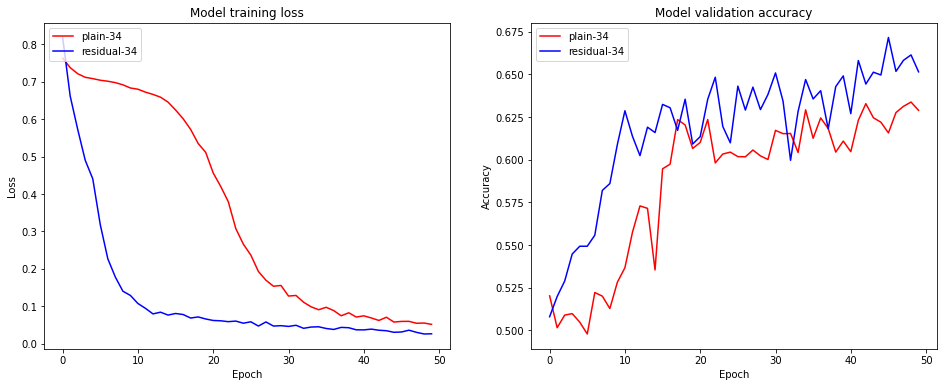

In [23]:
# 시각화
import matplotlib.pyplot as plt
figure = plt.figure(figsize=(16, 6))

plt.subplot(1, 2, 1)
plt.plot(history_34_plain.history['loss'], 'r')
plt.plot(history_34_residual.history['loss'], 'b')
plt.title('Model training loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['plain-34', 'residual-34'], loc='upper left')

plt.subplot(1, 2, 2)
plt.plot(history_34_plain.history['val_accuracy'], 'r')
plt.plot(history_34_residual.history['val_accuracy'], 'b')
plt.title('Model validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['plain-34', 'residual-34'], loc='upper left')
plt.show()

# ResNet 50 Residual Model

In [24]:
resnet50_residual = build_resnet(input_shape=(32, 32, 3), is_50=True, num_classes=2)

In [25]:
resnet50_residual.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 16, 16, 64)   9472        input_3[0][0]                    
__________________________________________________________________________________________________
batch_normalization_72 (BatchNo (None, 16, 16, 64)   256         conv1[0][0]                      
__________________________________________________________________________________________________
re_lu_66 (ReLU)                 (None, 16, 16, 64)   0           batch_normalization_72[0][0]     
____________________________________________________________________________________________

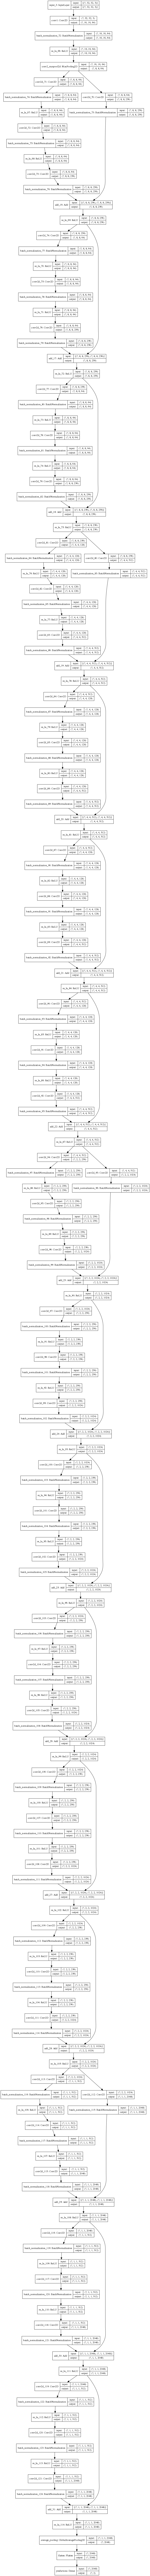

In [26]:
tf.keras.utils.plot_model(resnet50_residual, show_shapes=True, dpi=80)

# ResNet 50 Plain Model

In [27]:
resnet50_plain = build_resnet(input_shape=(32, 32, 3), is_plain=True, is_50=True, num_classes=2)

In [28]:
resnet50_plain.summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 16, 16, 64)        9472      
_________________________________________________________________
batch_normalization_125 (Bat (None, 16, 16, 64)        256       
_________________________________________________________________
re_lu_115 (ReLU)             (None, 16, 16, 64)        0         
_________________________________________________________________
conv2_maxpool2d (MaxPooling2 (None, 8, 8, 64)          0         
_________________________________________________________________
conv2d_123 (Conv2D)          (None, 8, 8, 64)          4160      
_________________________________________________________________
batch_normalization_127 (Bat (None, 8, 8, 64)          256 

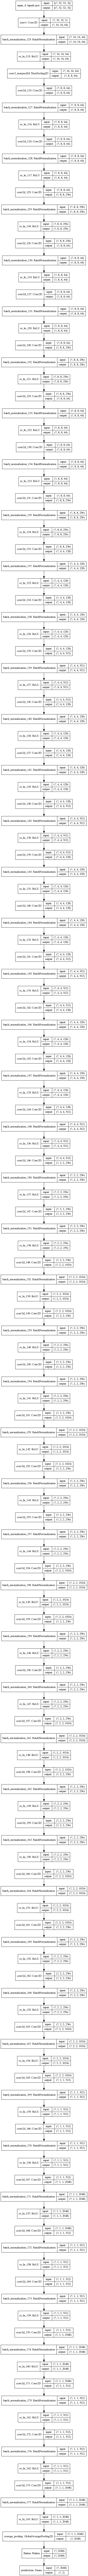

In [29]:
tf.keras.utils.plot_model(resnet50_plain, show_shapes=True, dpi=100)

# Train

In [31]:
BATCH_SIZE = 64
EPOCH = 50
# cats_vs_dogs dataset load
(ds_train, ds_test), ds_info = tfds.load(
    'cats_vs_dogs',
    split=['train[:80%]', 'train[80%:]'],
    as_supervised=True,
    shuffle_files=True,
    with_info=True,
)
ds_train = apply_normalize_on_dataset(ds_train, batch_size=BATCH_SIZE)
ds_test = apply_normalize_on_dataset(ds_test, batch_size=BATCH_SIZE)

In [32]:
# ResNet50-Plain
resnet50_plain.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01, clipnorm=1.),
    metrics=['accuracy'],
)

history_50_plain = resnet50_plain.fit(
    ds_train,
    steps_per_epoch=int(ds_info.splits['train[:80%]'].num_examples/BATCH_SIZE),
    validation_steps=int(ds_info.splits['train[80%:]'].num_examples/BATCH_SIZE),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/50
290/290 [==============================] - 73s 253ms/step - loss: 0.7588 - accuracy: 0.4964 - val_loss: 0.7018 - val_accuracy: 0.5052
Epoch 2/50
290/290 [==============================] - 17s 58ms/step - loss: 0.7388 - accuracy: 0.5026 - val_loss: 1.0768 - val_accuracy: 0.5057
Epoch 3/50
290/290 [==============================] - 17s 58ms/step - loss: 0.7297 - accuracy: 0.5029 - val_loss: 0.8094 - val_accuracy: 0.5020
Epoch 4/50
290/290 [==============================] - 17s 58ms/step - loss: 0.7274 - accuracy: 0.4978 - val_loss: 0.7231 - val_accuracy: 0.5028
Epoch 5/50
290/290 [==============================] - 18s 60ms/step - loss: 0.7195 - accuracy: 0.5046 - val_loss: 1.7328 - val_accuracy: 0.5078
Epoch 6/50
290/290 [==============================] - 17s 59ms/step - loss: 0.7159 - accuracy: 0.5098 - val_loss: 0.7625 - val_accuracy: 0.5063
Epoch 7/50
290/290 [==============================] - 17s 58ms/step - loss: 0.7131 - accuracy: 0.5049 - val_loss: 0.8547 - val_accuracy

In [33]:
# ResNet50-Residual
resnet50_residual.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01, clipnorm=1.),
    metrics=['accuracy'],
)

history_50_residual = resnet50_residual.fit(
    ds_train,
    steps_per_epoch=int(ds_info.splits['train[:80%]'].num_examples/BATCH_SIZE),
    validation_steps=int(ds_info.splits['train[80%:]'].num_examples/BATCH_SIZE),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/50
290/290 [==============================] - 26s 89ms/step - loss: 0.9592 - accuracy: 0.5104 - val_loss: 0.8972 - val_accuracy: 0.4900
Epoch 2/50
290/290 [==============================] - 18s 63ms/step - loss: 0.8650 - accuracy: 0.5134 - val_loss: 0.7874 - val_accuracy: 0.4996
Epoch 3/50
290/290 [==============================] - 21s 74ms/step - loss: 0.8210 - accuracy: 0.5166 - val_loss: 0.9049 - val_accuracy: 0.5365
Epoch 4/50
290/290 [==============================] - 18s 63ms/step - loss: 0.7996 - accuracy: 0.5246 - val_loss: 0.8886 - val_accuracy: 0.5178
Epoch 5/50
290/290 [==============================] - 18s 63ms/step - loss: 0.7779 - accuracy: 0.5289 - val_loss: 0.8645 - val_accuracy: 0.5373
Epoch 6/50
290/290 [==============================] - 18s 63ms/step - loss: 0.7578 - accuracy: 0.5431 - val_loss: 1.0956 - val_accuracy: 0.5233
Epoch 7/50
290/290 [==============================] - 18s 63ms/step - loss: 0.7581 - accuracy: 0.5478 - val_loss: 0.8799 - val_accuracy:

# Layer 50의 Plain, Residual 비교 결과
- plain보다 residual쪽이 더 빠르게 수렴되었다.

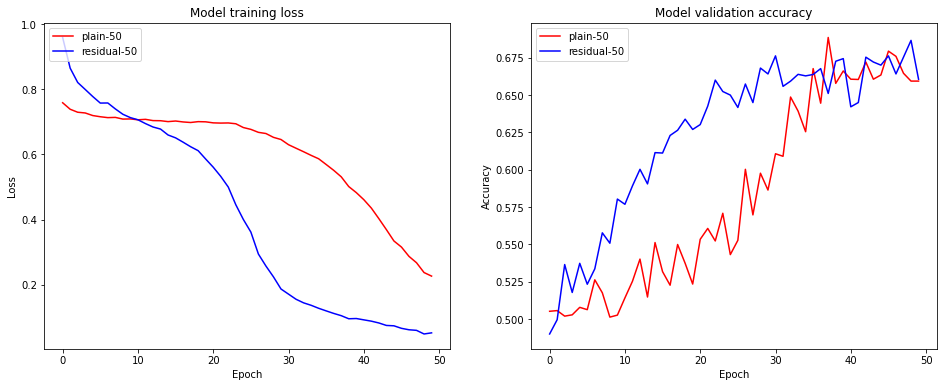

In [34]:
# 시각화
import matplotlib.pyplot as plt
figure = plt.figure(figsize=(16, 6))

plt.subplot(1, 2, 1)
plt.plot(history_50_plain.history['loss'], 'r')
plt.plot(history_50_residual.history['loss'], 'b')
plt.title('Model training loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['plain-50', 'residual-50'], loc='upper left')

plt.subplot(1, 2, 2)
plt.plot(history_50_plain.history['val_accuracy'], 'r')
plt.plot(history_50_residual.history['val_accuracy'], 'b')
plt.title('Model validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['plain-50', 'residual-50'], loc='upper left')
plt.show()

# ResNet 34 와 50의 비교
- 논문과는 다르게 34쪽이 더 빠르게 수렴했다
- 논문과 optimizer의 조건이 달라서 그런 것 같다.
- accuracy는 50쪽이 더 높았다.

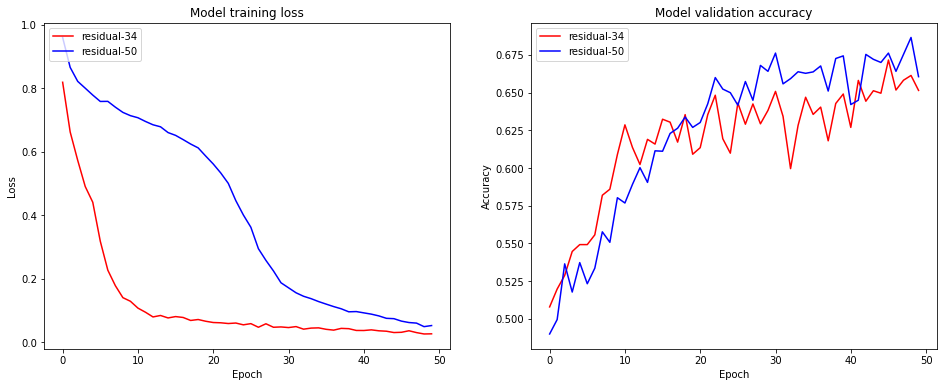

In [35]:
figure = plt.figure(figsize=(16, 6))

plt.subplot(1, 2, 1)
plt.plot(history_34_residual.history['loss'], 'r')
plt.plot(history_50_residual.history['loss'], 'b')
plt.title('Model training loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['residual-34', 'residual-50'], loc='upper left')

plt.subplot(1, 2, 2)
plt.plot(history_34_residual.history['val_accuracy'], 'r')
plt.plot(history_50_residual.history['val_accuracy'], 'b')
plt.title('Model validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['residual-34', 'residual-50'], loc='upper left')
plt.show()

# Tensorflow 내장 ResNet50 Model

In [36]:
resnet50 = tf.keras.applications.ResNet50(include_top=True, weights=None, input_shape=(32, 32, 3), classes=2)

In [37]:
resnet50.summary()

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 38, 38, 3)    0           input_5[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 16, 16, 64)   9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 16, 16, 64)   256         conv1_conv[0][0]                 
___________________________________________________________________________________________

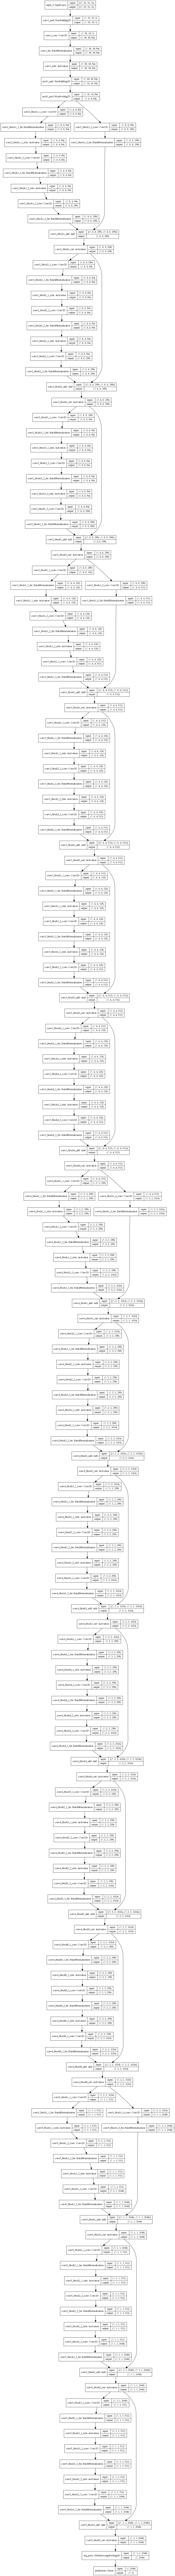

In [38]:
tf.keras.utils.plot_model(resnet50, show_shapes=True, dpi=64)

In [51]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  # 텐서플로가 첫 번째 GPU에 1GB 메모리만 할당하도록 제한
  try:
    tf.config.experimental.set_virtual_device_configuration(
        gpus[0],
        [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=1024 * 6)])
  except RuntimeError as e:
    # 프로그램 시작시에 가상 장치가 설정되어야만 합니다
    print(e)

Virtual devices cannot be modified after being initialized


In [52]:
# ResNet50-Residual
resnet50.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01, clipnorm=1.),
    metrics=['accuracy'],
)

history_resnet_50 = resnet50.fit(
    ds_train,
    steps_per_epoch=int(ds_info.splits['train[:80%]'].num_examples/BATCH_SIZE),
    validation_steps=int(ds_info.splits['train[80%:]'].num_examples/BATCH_SIZE),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/50


ResourceExhaustedError:  OOM when allocating tensor with shape[64,256,8,8] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[node resnet50/conv2_block3_3_bn/FusedBatchNormV3 (defined at <ipython-input-52-e8575c2f415d>:15) ]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.
 [Op:__inference_train_function_282204]

Function call stack:
train_function


# 직접 구현한 모델과 내장 모델 비교
- 혹시 구현이 잘못되었을 수도 있을 경우를 생각하여 내장 ResNet50을 이용하여 비교해보았으나 결과는 다르지 않았다.
- 직접 구현한 ResNet50은 내장 모델의 구조와 일치하였다.

In [ ]:
figure = plt.figure(figsize=(16, 6))

plt.subplot(1, 2, 1)
plt.plot(history_34_residual.history['loss'], 'r')
plt.plot(history_50_residual.history['loss'], 'b')
plt.plot(history_resnet_50.history['loss'], 'g')
plt.title('Model training loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['residual-34', 'residual-50', 'resnet50'], loc='upper left')

plt.subplot(1, 2, 2)
plt.plot(history_34_residual.history['val_accuracy'], 'r')
plt.plot(history_50_residual.history['val_accuracy'], 'b')
plt.plot(history_resnet_50.history['val_accuracy'], 'g')
plt.title('Model validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['residual-34', 'residual-50', 'resnet50'], loc='upper left')
plt.show()

## 회고록
- 매번 있는 모델만 복사 붙여넣기 하다가 처음으로 논문만 보고 모델을 바닥부터 짜는 것을 해보니 생각보다 쉽지 않았다.
- 특히 Block단위로 만드는 부분이 어려웠던 것 같다. 아무래도 익숙하지 않기 때문인 것 같다.
- 그래도 직접 모델을 구현해보니 다른 논문을 구현할 때 어떻게 해야 할지 조금은 감이 생긴 것 같다.
- 논문을 보고 똑같이 구현했음에도 불구하고 논문과 같은 결과를 얻진 못했다.